In [1]:
import pywt
import numpy as np
import csv
from scipy import stats
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.utils import resample

In [5]:
path = r'D:\6th SEM\mini project\MIT_BIH_KAGGLE\mitbih_database'
filenames = next(os.walk(path))[2]
records=list()
annotations=list()
filenames.sort()

In [6]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    if(file_extension=='.csv'):
        records.append(path+'/'+filename+file_extension)
    else:
        annotations.append(path+'/'+filename+file_extension)

records[0]

'D:\\6th SEM\\mini project\\MIT_BIH_KAGGLE\\mitbih_database/100.csv'

In [2]:
# 2.2. Save Scalogram as Image
# Converts scalogram data to an image and saves it to the specified directory.
def save_image(scalogram, label, index):
    """
    Saves the scalogram image with the given label and index.
    Args:
        scalogram: 2D array representing the scalogram.
        label: The label corresponding to the ECG class.
        index: Unique identifier for the image file.
    """
    image_size = (227, 227)  # Target size for AlexNet
    plt.figure(figsize=(image_size[0] / 100, image_size[1] / 100), dpi=100)
    plt.imshow(scalogram, aspect='auto', cmap='jet')
    plt.axis('off')
    plt.tight_layout(pad=0)
    image_path = os.path.join(image_dir, f'scalogram_{label}_{index}.png')
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

In [9]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
  #  print(len(coeffs))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')
    return datarec

In [10]:
# 3. Initialization
# Setting up global variables and directories.
X = []  # List to store ECG beats
y = []  # List to store labels
window_size = 180  # Window size for extracting ECG beats
scales = np.arange(1, 64)  # Scales for Continuous Wavelet Transform (CWT)
image_dir = 'images'  # Directory to save scalogram images

# Create the output directory if it does not exist
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

# Define classes and target samples
classes = ['N', 'L', 'R', 'A', 'V']  # Example class names
count_classes = [0] * len(classes)
target_samples_per_class = 2500  # Default target samples per class


In [11]:
# 4. Load and Preprocess Data
# Reading signal data and annotations, and preprocessing signals.
for r in range(len(records)):
    signals = []
    with open(records[r], 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row_index, row in enumerate(spamreader):
            if row_index > 0:  # Skip the header
                signals.append(int(row[1]))

    # Denoise and normalize the signals
    signals = denoise(signals)
    signals = stats.zscore(signals)

    # Read annotations and extract labeled beats
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        for d in range(1, len(data)):
            splitted = data[d].split()
            pos = int(splitted[1])
            arrhythmia_type = splitted[2]

            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                if window_size <= pos < (len(signals) - window_size):
                    beat = signals[pos - window_size:pos + window_size]
                    X.append(beat)
                    y.append(arrhythmia_index)


In [12]:
# 5. Resample Data
# Balancing dataset by resampling each class to the target number of samples.
resampled_X = []
resampled_y = []

# Define target samples per class
target_samples_per_class = {
    0: 10000,
    1: 7000,
    2: 7000,
    3: 5000,
    4: 7000
}

# Resample data for each class
for class_index in range(len(classes)):
    class_samples = [X[i] for i in range(len(X)) if y[i] == class_index]
    target_samples = target_samples_per_class[class_index]
    
    # Use different random states for reproducibility
    random_state = {0: 42, 1: 122, 2: 123, 3: 125, 4: 125}[class_index]
    resampled_class_samples = resample(class_samples, n_samples=target_samples, random_state=random_state)
    resampled_X.extend(resampled_class_samples)
    resampled_y.extend([class_index] * target_samples)


KeyboardInterrupt: 

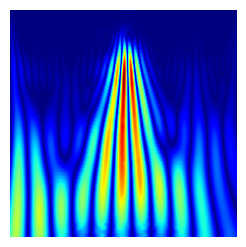

In [ ]:
# 6. Generate Scalograms
# Convert ECG beats to scalograms and save as images.
batch_index = 0
for i in range(len(resampled_X)):
    beat = resampled_X[i]
    label = resampled_y[i]
    coefficients, _ = pywt.cwt(beat, scales, 'morl')
    scalogram = np.abs(coefficients)
    save_image(scalogram, label, batch_index)
    batch_index += 1

# 7. Completion Message
# Display a message indicating the process is complete.
print(f"Saved {batch_index} scalogram images in the '{image_dir}' directory.")